In [4]:
#from tqdm import tqdm
from qiskit import quantum_info
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
import pickle
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy.random as random
#InteractiveShell.ast_node_interactivity = "all"

In [5]:
def Shat(A,T,G): 
    
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    Shatf = np.array([[1-t*tt,0,0,t+tt],[0,1+t*tt,t-tt,0],[0,-t+tt,1+t*tt,0],[-t-tt,0,0,1-t*tt]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat


def Gperm():
    Gperm = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    return Gperm


def Ur(A,T,G):  #NUMERICALLY CHECKED, CORRECT#
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)


def prodstaten(n):   #CHECKED#
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator


def K(T):
    
    K2 = Ur = np.zeros((2,2), dtype=complex)
    
    coef1 = np.cos(np.pi/4 + 1j*T/2)
    coef2 = np.cos(np.pi/4 - 1j*T/2)
    
    K2[0,0]=coef1
    K2[1,1]=coef2
    K2 = 1/np.sqrt(np.cosh(T)/2)*K2
    
    return K2

def Na(A,T,G):
    return 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)

def Nk(T):
    return (np.cosh(T/2))/2

dispcolors = {'cx':('#426299', '#000000'),
            'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

 
def Q(T,G):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.array([[1,0],[0,1]])
    Q = np.exp(-(G+T)/4)*np.kron(X,Id)+np.exp((T+G)/4)*np.kron(Z,X)
    return Q

def Qbar(T,G):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.array([[1,0],[0,1]])
    Qbar = np.exp((T-G)/4)*np.kron(Y,Id)+np.exp(-(T-G)/4)*np.kron(Z,Y)

    return Qbar

In [6]:
Ur(1,1,1)-Shat(1,1,1)

array([[ 1.24818702-0.3929817j ,  0.        +0.j        ,
         0.        +0.j        ,  0.37920611-0.37920611j],
       [ 0.        +0.j        ,  0.82058436-0.82058436j,
         0.80680877+0.04839655j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.04839655+0.80680877j,
         0.82058436-0.82058436j,  0.        +0.j        ],
       [-0.37920611+0.37920611j,  0.        +0.j        ,
         0.        +0.j        ,  0.3929817 -1.24818702j]])

In [3]:
#check supercharge commutations

A,T,G=3,3,3

print('Commutations for Ur: ',np.allclose(Q(T,G)@Ur(A,T,G)-Ur(A,T,G)@Q(-T,-G),0*np.eye(4)),
np.allclose(Qbar(T,G)@Ur(A,T,G)-Ur(A,T,G)@Qbar(-T,-G),0*np.eye(4)))


Commutations for Ur:  True True


In [8]:
A,T,G=1,1,1



S12= (1/np.sqrt(Na(A,T,G)))*np.kron(Shat(A,T,G),np.eye(2**2))

S34 = (1/np.sqrt(Na(A,T,G)))*np.kron(np.eye(2**2),Shat(A,T,G))

S23 = np.kron(np.eye(2),np.kron(Shat(A,T,G),np.eye(2)))

layer1 = S12@S34

coef = (1/16)*((1/np.sinh(T/2))**(2))*(2*A**(2)*np.cosh(G)+2*A**(2)*np.cosh(T)+np.sinh(T)**(2))    

layer2 = (1/np.sqrt(coef))*K1(-T/2)@S23@K4(T/2)

#print(layer1@layer1)

NameError: name 'K1' is not defined

In [5]:
#unitarity first layer
np.allclose(layer1@layer1.conj().T,np.eye(16))

False

In [6]:
#unitarity second layer 
np.allclose(layer2@layer2.conj().T, np.eye(16))

NameError: name 'layer2' is not defined

In [7]:
#unitarity whole circuit (odd+even)
np.allclose((layer2@layer1)@(layer2@layer1).conj().T,np.eye(16))

NameError: name 'layer2' is not defined

In [182]:
#4 qubit circuit
A,T,G=1,1,1



layers=1
qc=QuantumCircuit(4)
l=0
while l<layers:
    matrix = layer2@layer1
    qc.unitary(matrix,[0,1,2,3])
    qc.barrier(range(4))
    l+=1
    
##################################################################
            

In [53]:
#OBC BIPARTITION 4 sites, varying layers per datapoint


#Circuit parameters
n=4;A=1.2;G=20;

#Define arrays
 
thetas= np.arange(1e-3,10,0.01)
layers = [1]
ent_entropy4 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi4 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho4 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [0,1]
p_th=0.05


for m,layer in enumerate(layers):
    
    for f,T in enumerate(thetas):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            ##########
            qc.unitary(Shat(A,T,G),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)
                
            qc.unitary(Shat(A,T,G),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
                
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)
                
            qc.unitary(Shat(A,T,G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)
                
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)
            ##########
            qc.unitary(Shat(A,T,0),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)
            qc.unitary(Shat(A,T,0),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)
            qc.unitary(Shat(A,T,-G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)
            ################
            qc.unitary(Shat(A,T,-G),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)
            qc.unitary(Shat(A,T,-G),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
                
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)
            qc.unitary(Shat(A,T,-G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)
            ################
            qc.unitary(Shat(A,T,0),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)
            qc.unitary(Shat(A,T,0),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)
                
            qc.unitary(Shat(A,T,G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)
            qc.barrier(range(4))
            l+=1
                  
        #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        qc.draw(output='mpl')
        #raise KeyboardInterrupt
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho4[m,f,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi4[m,f]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy4[m,f]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

Text(0, 0.5, 'RE')

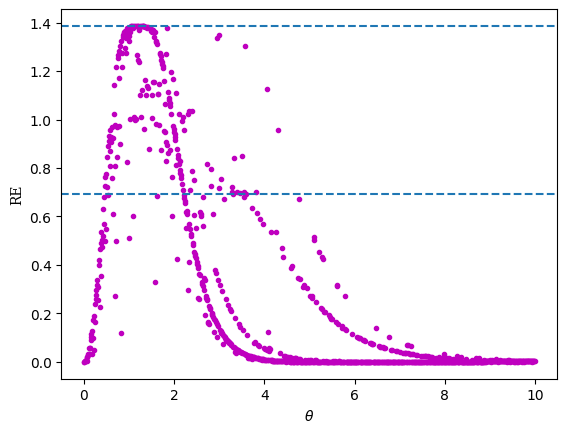

In [54]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    plt.plot(thetas,renyi4[j]+j*np.log(2),'.', c='m',label='L=4')
    color2 = next(color_cycle2)
    #plt.plot(thetas,renyi4[j],'-.', c=color2,label='RE')
    
    
#plt.plot(thetas,eigvalsrho4[0,:],'-.')


#plt.title('OBC N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$',**csfont)
plt.ylabel('RE', **csfont)
#plt.xlim(-0.2,3.8)
#plt.ylim(0,3)
#plt.legend()   
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC 4 site A=1.2 G=20.pdf", bbox_inches='tight')  

1


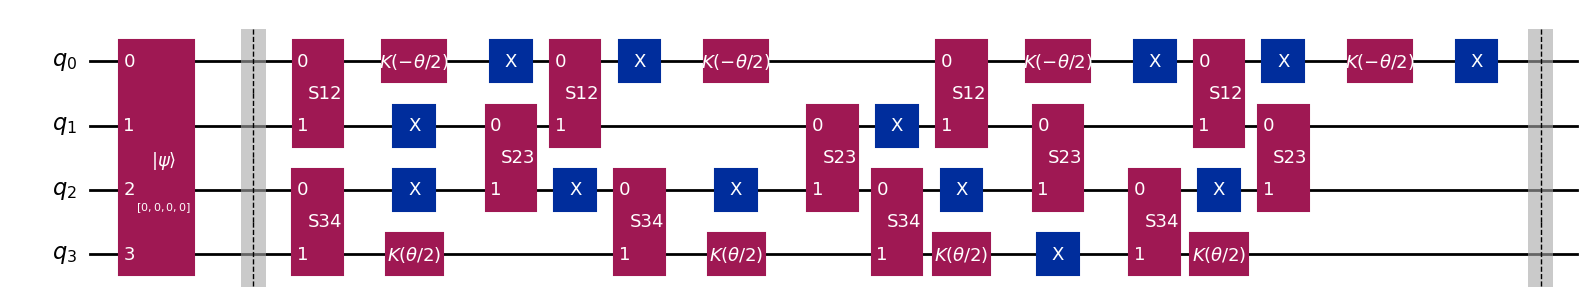

In [5]:
#drawing circuit for stochastic noise, debug
#Circuit parameters
n=4;A=1.2;G=20;

#Define arrays
 
layers = [1]

p_th=0.7


for m,layer in enumerate(layers):
    print(layer)
    
    
        
        
    string = "0" * (n)
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)
    #init with Kareljan's state
    #qc.unitary(prodstaten(n), range(0,n))
    qc.barrier(range(n))
    l=0
    while l<layer:
        ##########
        qc.unitary(Shat(A,T,G),[0,1],label='S12')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([0, 1])
            qc.x(flip)
            
        qc.unitary(Shat(A,T,G),[2,3],label='S34')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([2, 3])
            qc.x(flip)
            
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(0)
            
        qc.unitary(Shat(A,T,G),[1,2],label='S23')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([1, 2])
            qc.x(flip)
            
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(3)
        ##########
        qc.unitary(Shat(A,T,0),[0,1],label='S12')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([0, 1])
            qc.x(flip)
        qc.unitary(Shat(A,T,0),[2,3],label='S34')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([2, 3])
            qc.x(flip)
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(0)
        qc.unitary(Shat(A,T,-G),[1,2],label='S23')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([1, 2])
            qc.x(flip)
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(3)
        ################
        qc.unitary(Shat(A,T,-G),[0,1],label='S12')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([0, 1])
            qc.x(flip)
        qc.unitary(Shat(A,T,-G),[2,3],label='S34')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([2, 3])
            qc.x(flip)
            
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(0)
        qc.unitary(Shat(A,T,-G),[1,2],label='S23')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([1, 2])
            qc.x(flip)
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(3)
        ################
        qc.unitary(Shat(A,T,0),[0,1],label='S12')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([0, 1])
            qc.x(flip)
        qc.unitary(Shat(A,T,0),[2,3],label='S34')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([2, 3])
            qc.x(flip)
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(0)
            
        qc.unitary(Shat(A,T,G),[1,2],label='S23')
        k=np.random.rand(1)
        if k<p_th:
            flip = random.choice([1, 2])
            qc.x(flip)
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        k=np.random.rand(1)
        if k<p_th:
            qc.x(3)
        qc.barrier(range(4))
        l+=1
              
#qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
qc.draw(output='mpl')

In [12]:
#debug 4 sites
n=4;A=1.2;G=20;T=0.2
string = "0" * (n)
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))
layer=1
l=0
while l<layer:
    qc.unitary(Shat(A,T,G),[0,1],label='S12')
    qc.unitary(Shat(A,T,G),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12')
    qc.unitary(Shat(A,T,0),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12')
    qc.unitary(Shat(A,T,0),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    qc.barrier(range(4))
    l+=1
qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

########################################################################    
##access density matrix  
#rho = DensityMatrix(qc)
#
#reduced_rho=partial_trace(rho, subsystem)
#
##find the eigenvalues of the reduced density matrix
#eigenvalues,_ = np.linalg.eig(reduced_rho)
#
##compute the entanglement entropy
#
#order = eigenvalues.argsort()
#eigenvalues = eigenvalues[order]
#
#entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
#
#print(entanglement_entropy)

NameError: name 'basis_gates' is not defined

In [285]:
from qiskit.quantum_info import Statevector

# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**n)

# Evolve the state by the quantum circuit
state = state.evolve(qc)


#draw using latex
state.draw('latex')

#Alternative way of representing in latex
#array_to_latex(state)



<IPython.core.display.Latex object>

In [49]:
#OBC BIPARTITION 6 sites, varying layers per datapoint


#Circuit parameters
n=6
A,G,=1,20
#Define arrays
 
thetas= np.arange(1e-3,5,0.05)
layers = [1]
ent_entropy6 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi6 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho6 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [j for j in range(n//2)]

basis_gates=['cx', 'id', 'rz', 'x', 'sx']

print(subsystem)

for m,layer in enumerate(layers):
    print(layer)
    
    for k,T in tqdm(enumerate(thetas)):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.barrier(range(n))
            l+=1
        qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho6[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi6[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy6[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

[0, 1, 2]
1


100it [00:18,  5.49it/s]


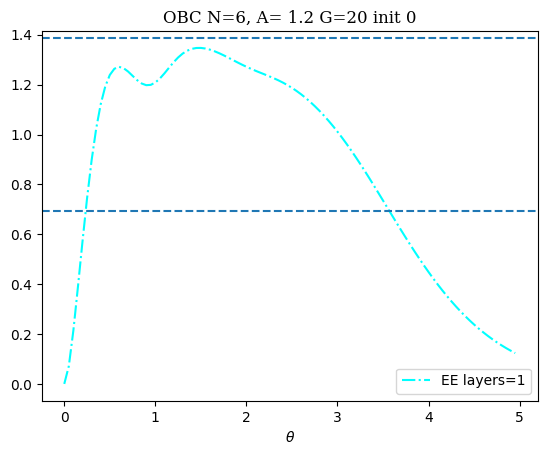

In [50]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    plt.plot(thetas,ent_entropy6[j],'-.', c=color1,label='EE layers='+str(layer))
    color2 = next(color_cycle2)
    #plt.plot(thetas,renyi6[j],'-.', c=color2,label='RE')
    
    
#plt.plot(thetas,eigvalsrho6[0,:],'-,')


plt.title('OBC N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$',**csfont)
#plt.xlim(-0.2,3.8)
#plt.ylim(-0,3)
plt.legend()   


In [51]:
np.where(renyi6>1.3)

(array([0, 0, 0, 0]), array([28, 29, 30, 31]))

In [52]:
np.max(renyi6)

(1.3110738269804094+2.873885292783116e-16j)

In [14]:
#debug 6 
n=6;A=1.2;G=20;T=0.2

#layers = [1]
#ent_entropy = np.zeros((len(layers),len(thetas)),dtype=complex)
#renyi = np.zeros((len(layers),len(thetas)),dtype=complex)
#eigvalsrho = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
#subsystem = [0,1,2]
basis_gates=['rzz', 'x','y','z']
string = "0" * (n)
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))
l=0
while l<layer:
    qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.barrier(range(n))
    l+=1
qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

#######################################################################    
#access density matrix  
rho = DensityMatrix(qc)
reduced_rho=partial_trace(rho, subsystem)
#find the eigenvalues of the reduced density matrix
eigenvalues,_ = np.linalg.eig(reduced_rho)
#compute the entanglement entropy
order = eigenvalues.argsort()
eigenvalues = eigenvalues[order]
eigvalsrho[m,k,:]= eigenvalues
entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
renyi[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
ent_entropy[m,k]=entanglement_entropy
#print(k,ent_entropy[k])
######################################################################
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

TranspilerError: "Unable to translate the operations in the circuit: ['u', 'cx', 'barrier', 'reset'] to the backend's (or manually specified) target basis: ['x', 'measure', 'delay', 'barrier', 'y', 'reset', 'z', 'rzz', 'snapshot']. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/transpiler_passes.BasisTranslator#translation-errors"

In [ ]:
#OBC BIPARTITION 8 sites, varying layers per datapoint


#Circuit parameters
n=8;A=1.2;G=20;

#Define arrays
 
thetas= np.arange(1e-3,10,0.05)
layers = [1]
ent_entropy8 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi8 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho8 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [j for j in range(n//2)]

basis_gates=['exc', 'id', 'rz', 'x', 'sx']

print(subsystem)

for m,layer in enumerate(layers):
    print(layer)
    
    for k,T in tqdm(enumerate(thetas)):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(Shat(A,T,G),[6,7],label='S78 G')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(Shat(A,T,-G),[6,7],label='S78 -')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            qc.barrier(range(n))
            l+=1
        qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho8[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi8[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy8[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

[0, 1, 2, 3]
1


63it [00:57,  1.08it/s]

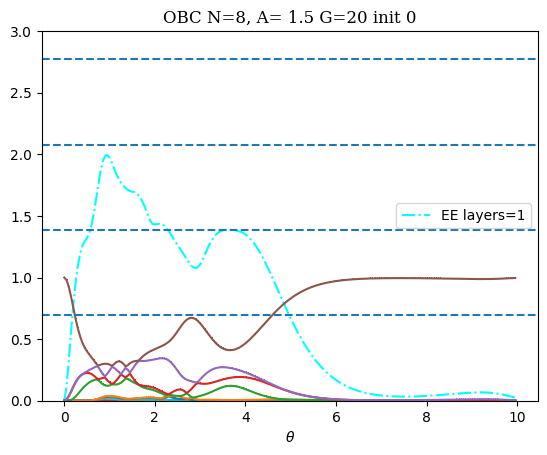

In [63]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    plt.plot(thetas,ent_entropy8[j]+j*np.log(2),'-.', c=color1,label='EE layers='+str(layer))
    color2 = next(color_cycle2)
    #plt.plot(thetas,renyi8[j],'-.', c=color2,label='RE')
    
    
plt.plot(thetas,eigvalsrho8[0,:],'-,')


plt.title('OBC N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,5):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$',**csfont)
#plt.xlim(-0.2,3.8)
plt.ylim(-0,3)
plt.legend()   


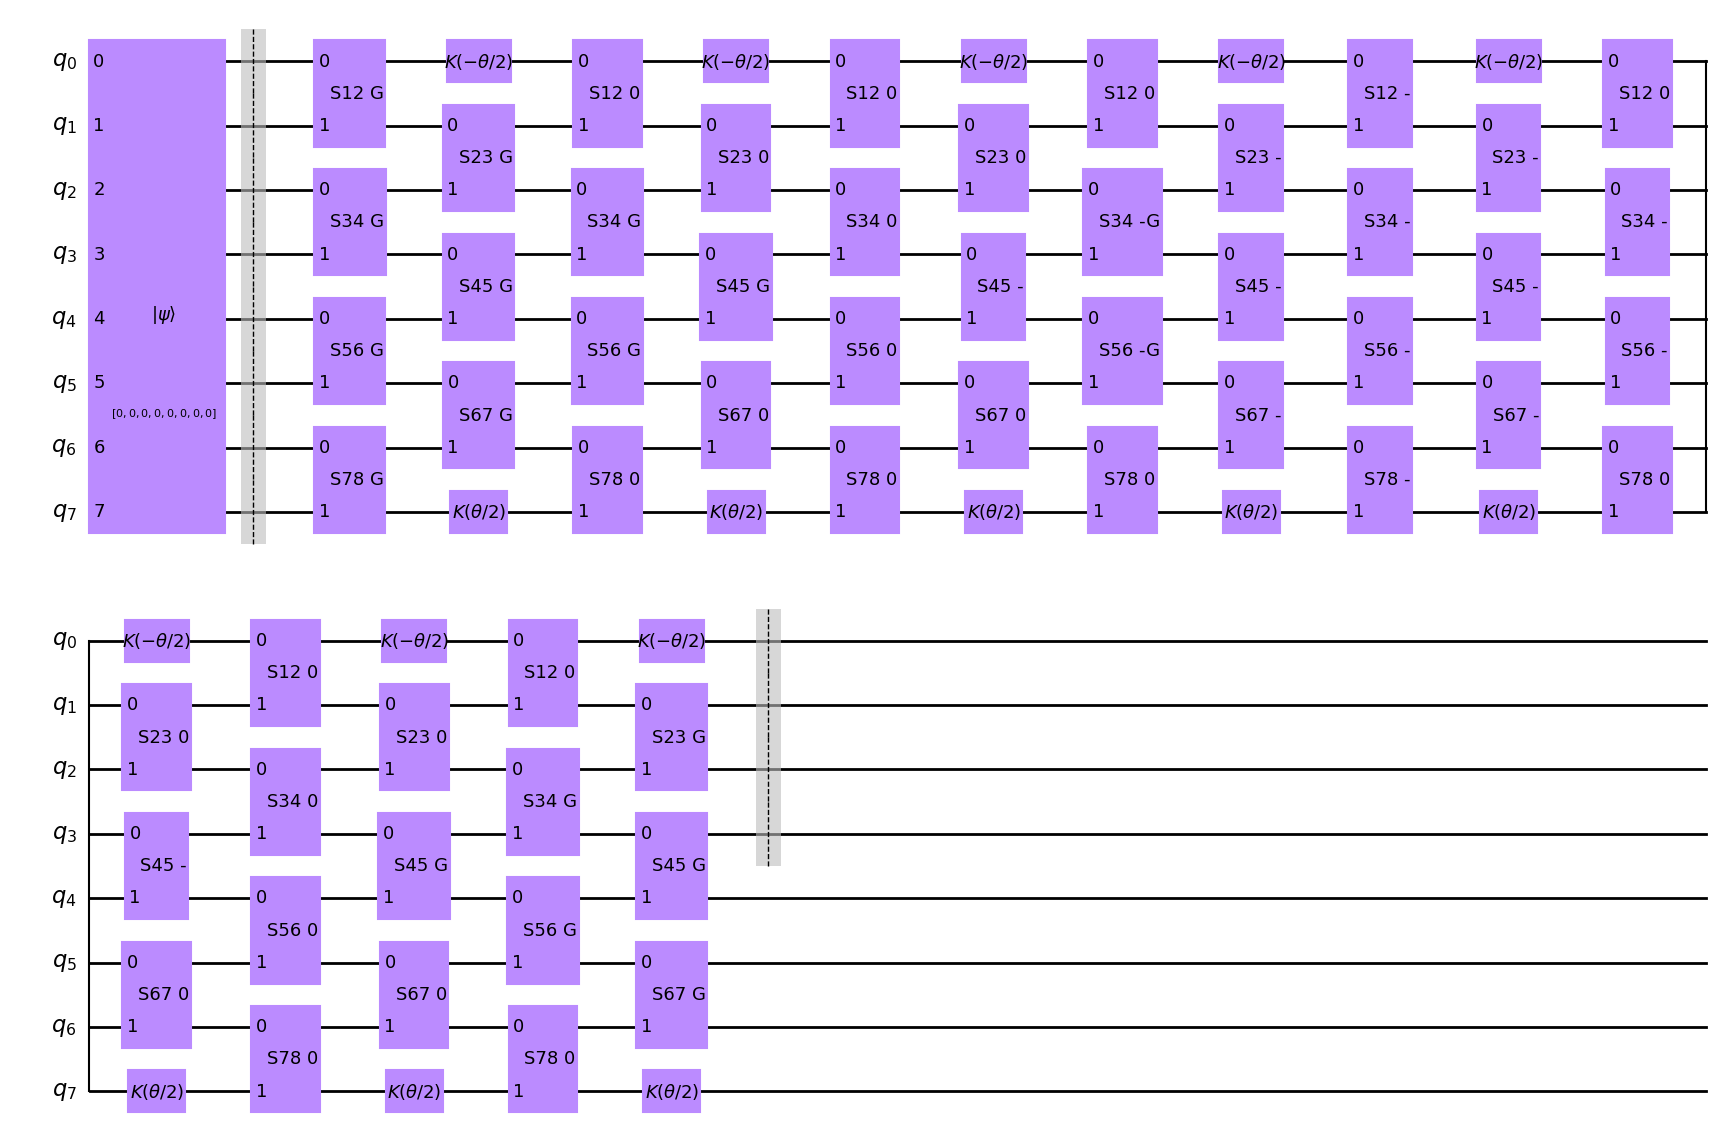

In [413]:
#debug 8 site
A=1;G=0;n=8
string = "0" * (n)
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))
l=0
while l<layer:
    qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(Shat(A,T,G),[6,7],label='S78 G')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(Shat(A,T,-G),[6,7],label='S78 -')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.barrier(range(4))
    l+=1
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

/home/alberto/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


NameError: name 'renyi6' is not defined

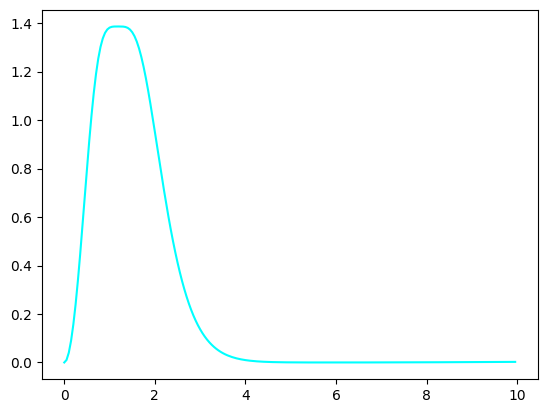

In [23]:
#PLOT ALL SIZES
csfont = {'fontname':'Serif'}
thetas= np.arange(1e-3,10,0.05)

from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, 3)))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, 3)))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy4[j],'-.', c=color1,label='EE size=4')
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi4[j],'-', c=color1,label='L=4')
    
for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy6[j],'-.', c=color1,label='EE size=6')
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi6[j],'-', c=color1,label='L=6')
    
for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy8[j],'-.', c=color1,label='EE size=8')
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi8[j],'-', c=color1,label='L=8')
    



#plt.title('OBC A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,4):
    plt.axhline(y=j*np.log(2), linestyle='--')
    
plt.xlabel(r'$\theta$', **csfont)
plt.xlabel(r'$\theta$')
#plt.xlim(-0.2,3.8)
#plt.ylim(-0.1,1.5)
plt.legend()   
plt.show()
plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC 4,6,8 site A=1.2 G=20.pdf", bbox_inches='tight')  